In [ ]:

library(Seurat)
#library(tidyverse)
library(ggplot2)
library(scales)
library(dplyr)
#library(DoubletFinder)
library(glmGamPoi)
library(openxlsx)
library(HGNChelper)
set.seed(411)
print("m")
options(future.globals.maxSize = 3 * 1024^3) 

#MULTIMODAL NEIGHBORS STEP TKAES TOO LOMG NEXT TIE RUN IN A SCREEN

library("harmony")

paths <- c(
    "/share/hennlab/projects/NCR_scRNAseq/scripts/seurat/testbox/TBSS04_basic_seurat.rds",
    "/share/hennlab/projects/NCR_scRNAseq/scripts/seurat/testbox/TBSS07_basic_seurat.rds",
    "/share/hennlab/projects/NCR_scRNAseq/scripts/seurat/testbox/TBSS12_basic_seurat.rds",
    "/share/hennlab/projects/NCR_scRNAseq/scripts/seurat/testbox/TBSS13_basic_seurat.rds",
    "/share/hennlab/projects/NCR_scRNAseq/scripts/seurat/testbox/TBSS18_basic_seurat.rds")

# Load Seurat objects
seurat_list <- lapply(paths, readRDS)
#(files are reead

# pipeline is to create merged object using Harmony begons here
#Merge Seurat objects
batch1_combined <- Reduce(function(x, y) merge(x, y), seurat_list)
combined$batch <- "batch1"
head(combined@meta.data)

ncol(combined)



VlnPlot(combined, features = c("nFeature_RNA"), group.by = "orig.ident") + guides(fill = "none") 
# basc qc
#violin plot
VlnPlot(combined, features = c("nCount_RNA"), group.by = "orig.ident") + guides(fill = "none")  

#violin plot
VlnPlot(combined, features = c("percent.mt"), group.by = "orig.ident") + guides(fill = "none")

VlnPlot(combined, features = c("nCount_ADT"), group.by = "orig.ident") + guides(fill = "none")  

VlnPlot(combined, features = c("nFeature_ADT"), group.by = "orig.ident") + guides(fill = "none")  

FeatureScatter(combined, feature1 = "nCount_RNA", feature2 = "percent.mt")  
 

FeatureScatter(combined, feature1 = "nCount_ADT", feature2 = "nFeature_ADT") 
 

VlnPlot(combined, features = c("percent.ribo"), group.by = "orig.ident") + guides(fill = "none") 
 

# Process RNA data with standard workflow
combined <- NormalizeData(combined, assay = "RNA", normalization.method = "LogNormalize") %>%
  FindVariableFeatures(assay = "RNA", selection.method = "vst", nfeatures = 2000) %>%    # Specify RNA assay for variable feature selection
  ScaleData(assay = "RNA") %>%               # Specify RNA assay for scaling
  RunPCA(assay = "RNA",reduction.name = "pca", reduction.key = "PCA_") %>% # Specify RNA assay for PCA
  FindNeighbors(assay = "RNA", dims = 1:50)  %>%
  FindClusters(assay = "RNA",  resolution = 1.2)  %>%
  RunUMAP(reduction = 'pca', dims = 1:50, assay = 'RNA', 
              reduction.name = 'rna.umap', reduction.key = 'rnaUMAP_')
print("processed combined RNA data")


# Process ADT data
combined <- NormalizeData(combined, assay = "ADT", normalization.method = "CLR",margin = 2) %>%
  ScaleData(assay = "ADT")

# Run PCA on all ADT features
adt_features <- rownames(combined[["ADT"]])  # Get all ADT features
combined <- RunPCA(combined, assay = "ADT", features = adt_features, reduction.name = "apca", reduction.key = "APCA_") %>%
  FindNeighbors(assay = "ADT", dims = 1:50) %>%
  FindClusters(assay = "ADT", resolution = 1.2) %>%
  RunUMAP(reduction = 'apca', dims = 1:50, assay = 'ADT', 
          reduction.name = 'adt.umap', reduction.key = 'adtUMAP_')

options(repr.plot.width = 20, repr.plot.height = 12)

DimPlot(combined, reduction = 'rna.umap',   label = TRUE, repel = TRUE, label.size = 5.5) 
  
 
DimPlot(combined, reduction = 'adt.umap',  label = TRUE, repel = TRUE, label.size = 7.5) + NoLegend()

In [14]:
combined <- FindMultiModalNeighbors(combined, reduction.list = list("pca", "apca"), dims.list = list(1:50, 1:50),modality.weight.name = c("RNA.weight", "ADT.weight"))

 
 

combined <- RunUMAP(combined, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
combined <- FindClusters(combined, graph.name = "wsnn", algorithm = 3, resolution = 2, verbose = FALSE)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

12:28:45 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

12:28:47 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

12:28:49 1 smooth knn distance failures

12:28:53 Initializing from normalized Laplacian + noise (using RSpectra)

12:29:01 Commencing optimization for 200 epochs, with 5188656 positive edges

12:35:14 Optimization finished



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“ggrepel: 45 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


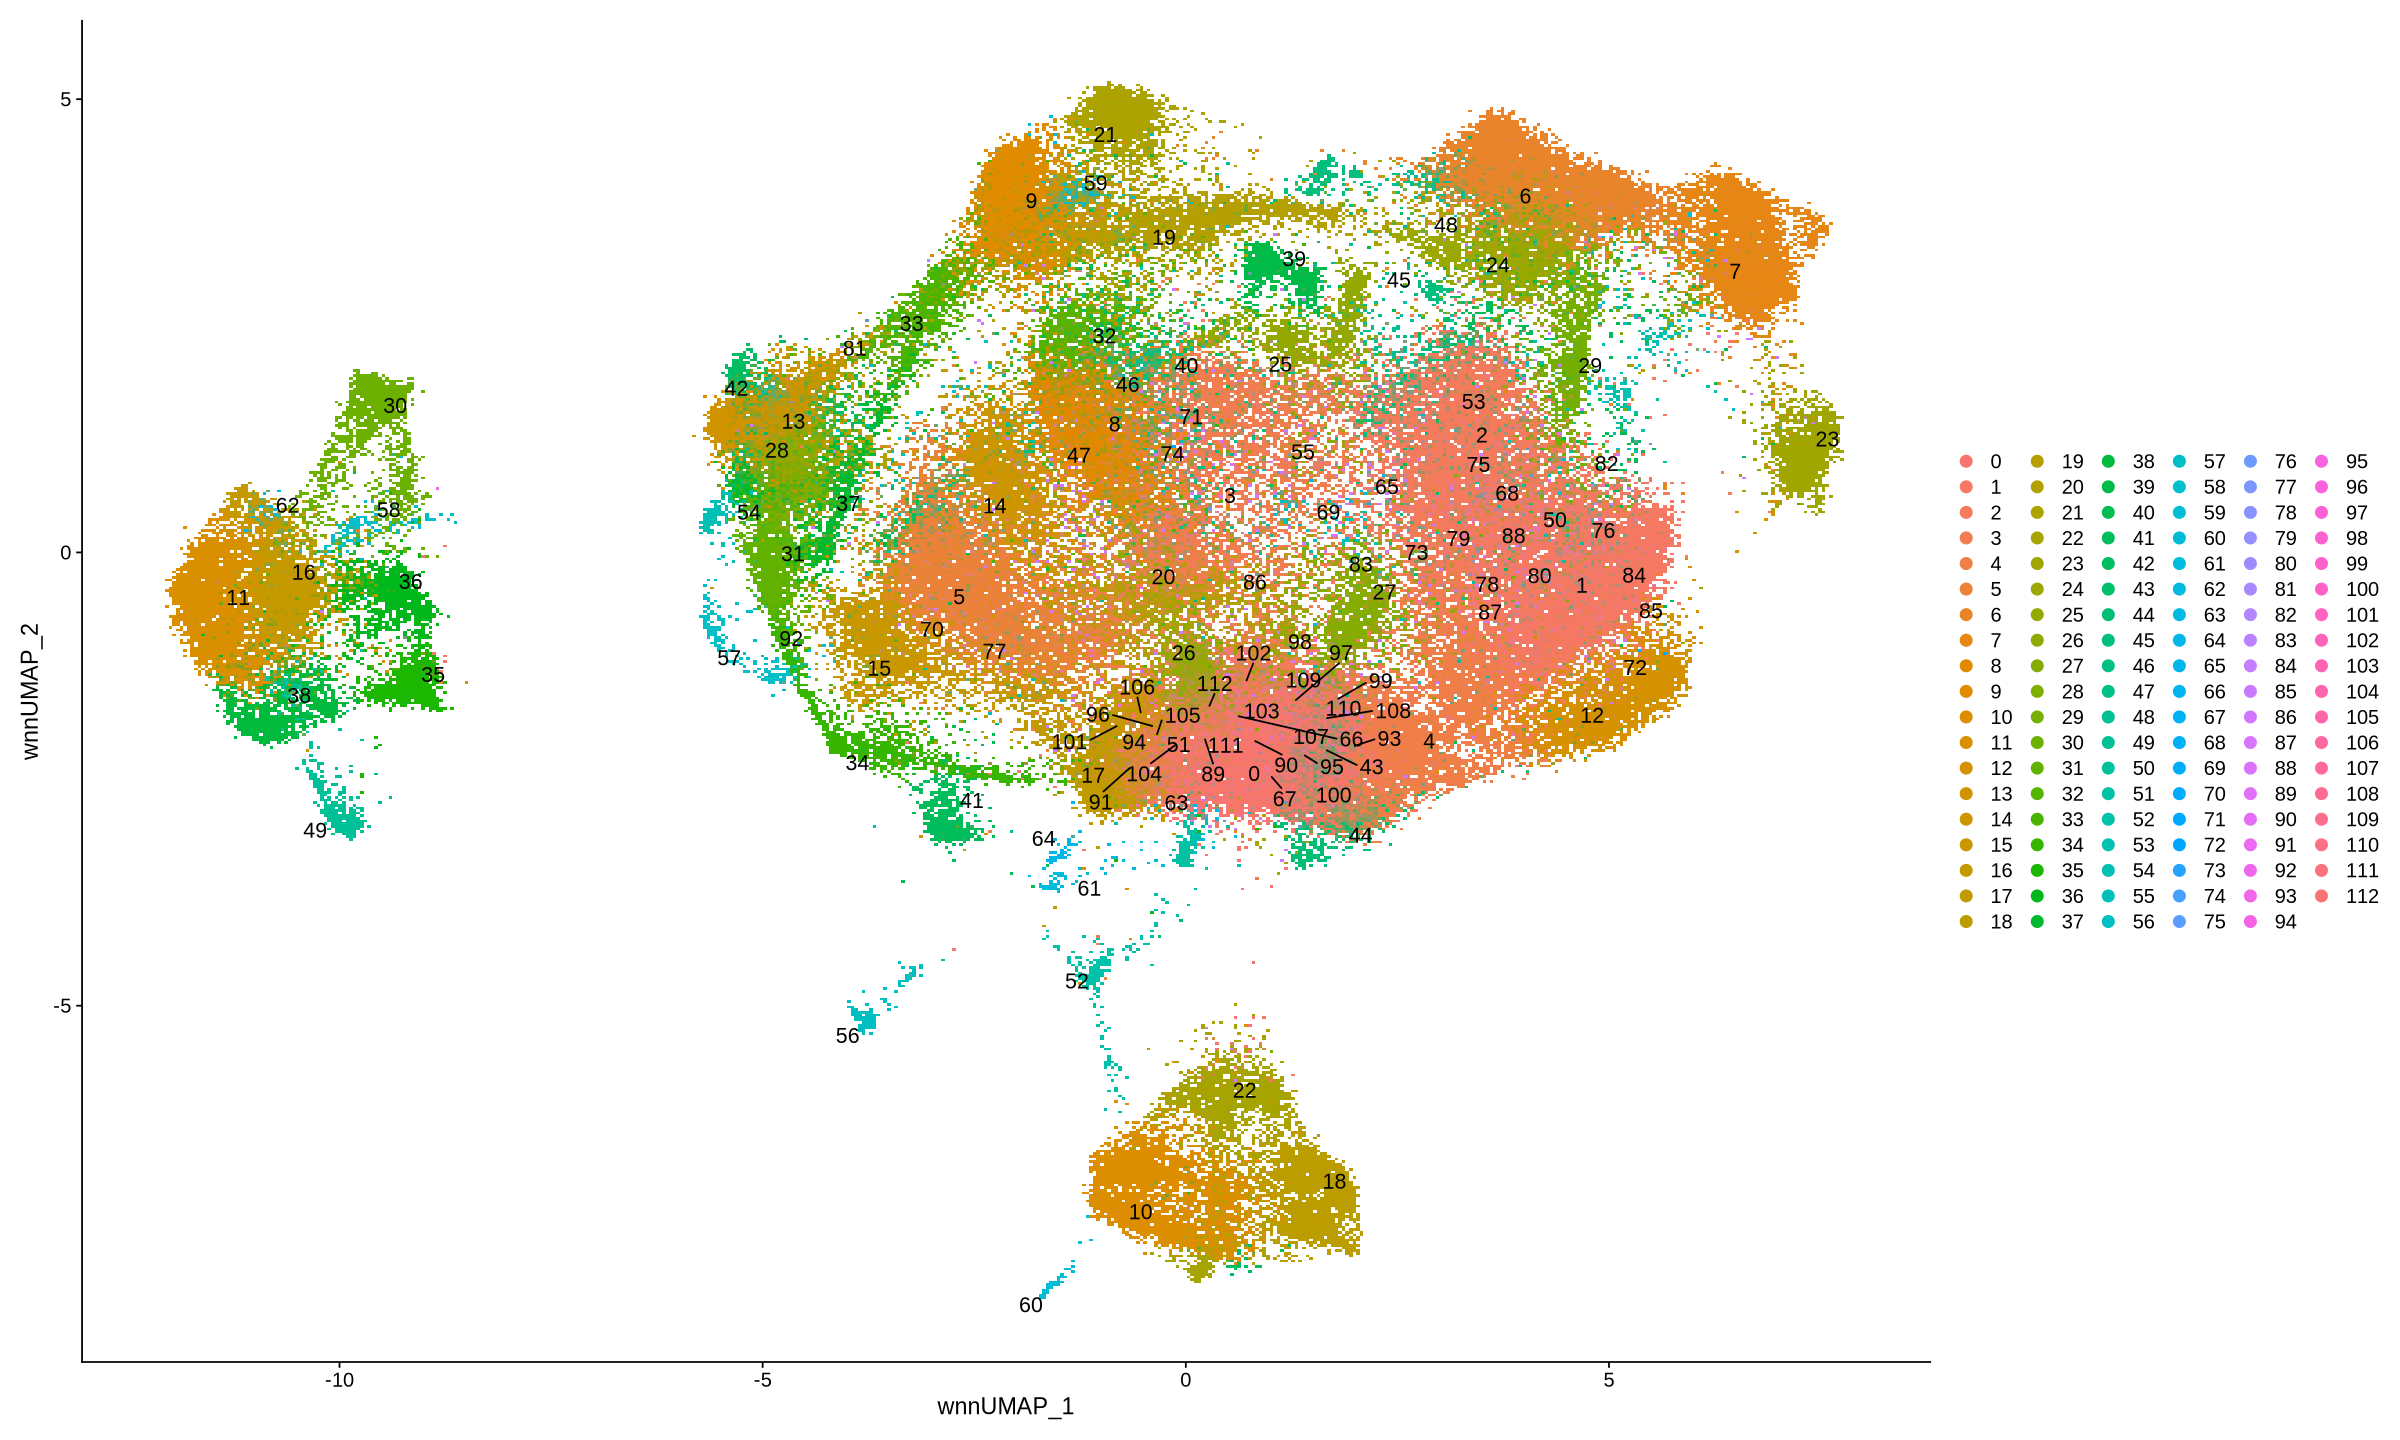

In [15]:
DimPlot(combined, reduction = 'wnn.umap', label = TRUE, repel = TRUE, label.size = 4.5) 



#saveRDS(combined, file = "/share/hennlab/projects/NCR_scRNAseq/results/seurat/combined_nointegration.rds")

In [ ]:

#above here then run harmony/seuratintegrate

source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/gene_sets_prepare.R")
# load cell type annotation function
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_score_.R")
gs.list <- gene_sets_prepare("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/ScTypeDB_short.xlsx", "Immune system") # e.g. Imm
es.max <- sctype_score(GetAssayData(combined, assay = "RNA", layer = "scale"),
                       scaled = TRUE,
                       gs = gs.list$gs_positive,
                       gs2 = gs.list$gs_negative)

In [17]:
# merge by cluster
cL_resutls <- do.call("rbind", lapply(unique(combined@meta.data$seurat_clusters), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(combined@meta.data[combined@meta.data$seurat_clusters==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(combined@meta.data$seurat_clusters==cl)), 10)
}))
sctype_scores <- cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  

sctype_scores <- sctype_scores %>%
  mutate(type = if_else(as.numeric(as.character(scores)) < ncells / 4, "Unknown", type))
print(sctype_scores[,1:3])
del2 <- sctype_scores %>%
  filter(type == "Unknown") %>%
  arrange(desc(column_name))
print
combined@meta.data$sctype_classification = ""
for(j in unique(sctype_scores$cluster)){
  cl_type = sctype_scores[sctype_scores$cluster==j,]; 
  combined@meta.data$sctype_classification[combined@meta.data$seurat_clusters == j] = as.character(cl_type$type[1])
}

# A tibble: 113 × 3
# Groups:   cluster [113]
   cluster type                        scores
   <fct>   <chr>                        <dbl>
 1 15      Natural killer  cells        9705.
 2 5       Natural killer  cells       14554.
 3 6       Naive CD4+ T cells           3469.
 4 20      ISG expressing immune cells   948.
 5 1       Naive CD4+ T cells           7239.
 6 12      Naive CD8+ T cells           3557.
 7 11      Classical Monocytes         30403.
 8 16      Classical Monocytes         22339.
 9 14      CD8+ NKT-like cells          6172.
10 25      γδ-T cells                   3280.
# ℹ 103 more rows


In [ ]:
DimPlot(combined, reduction = 'wnn.umap',  group.by = 'sctype_classification' , label = TRUE, repel = TRUE, label.size = 5.5) 

In [ ]:
# Extract the metadata
metadata <- combined@meta.data

# Count the number of cells for each cell type in the 'sctype_classification' column
cell_type_counts <- metadata %>%
  group_by(sctype_classification) %>%
  summarise(cell_count = n()) %>%
  arrange(desc(cell_count))

# Display the table
print(cell_type_counts, n = Inf)  

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



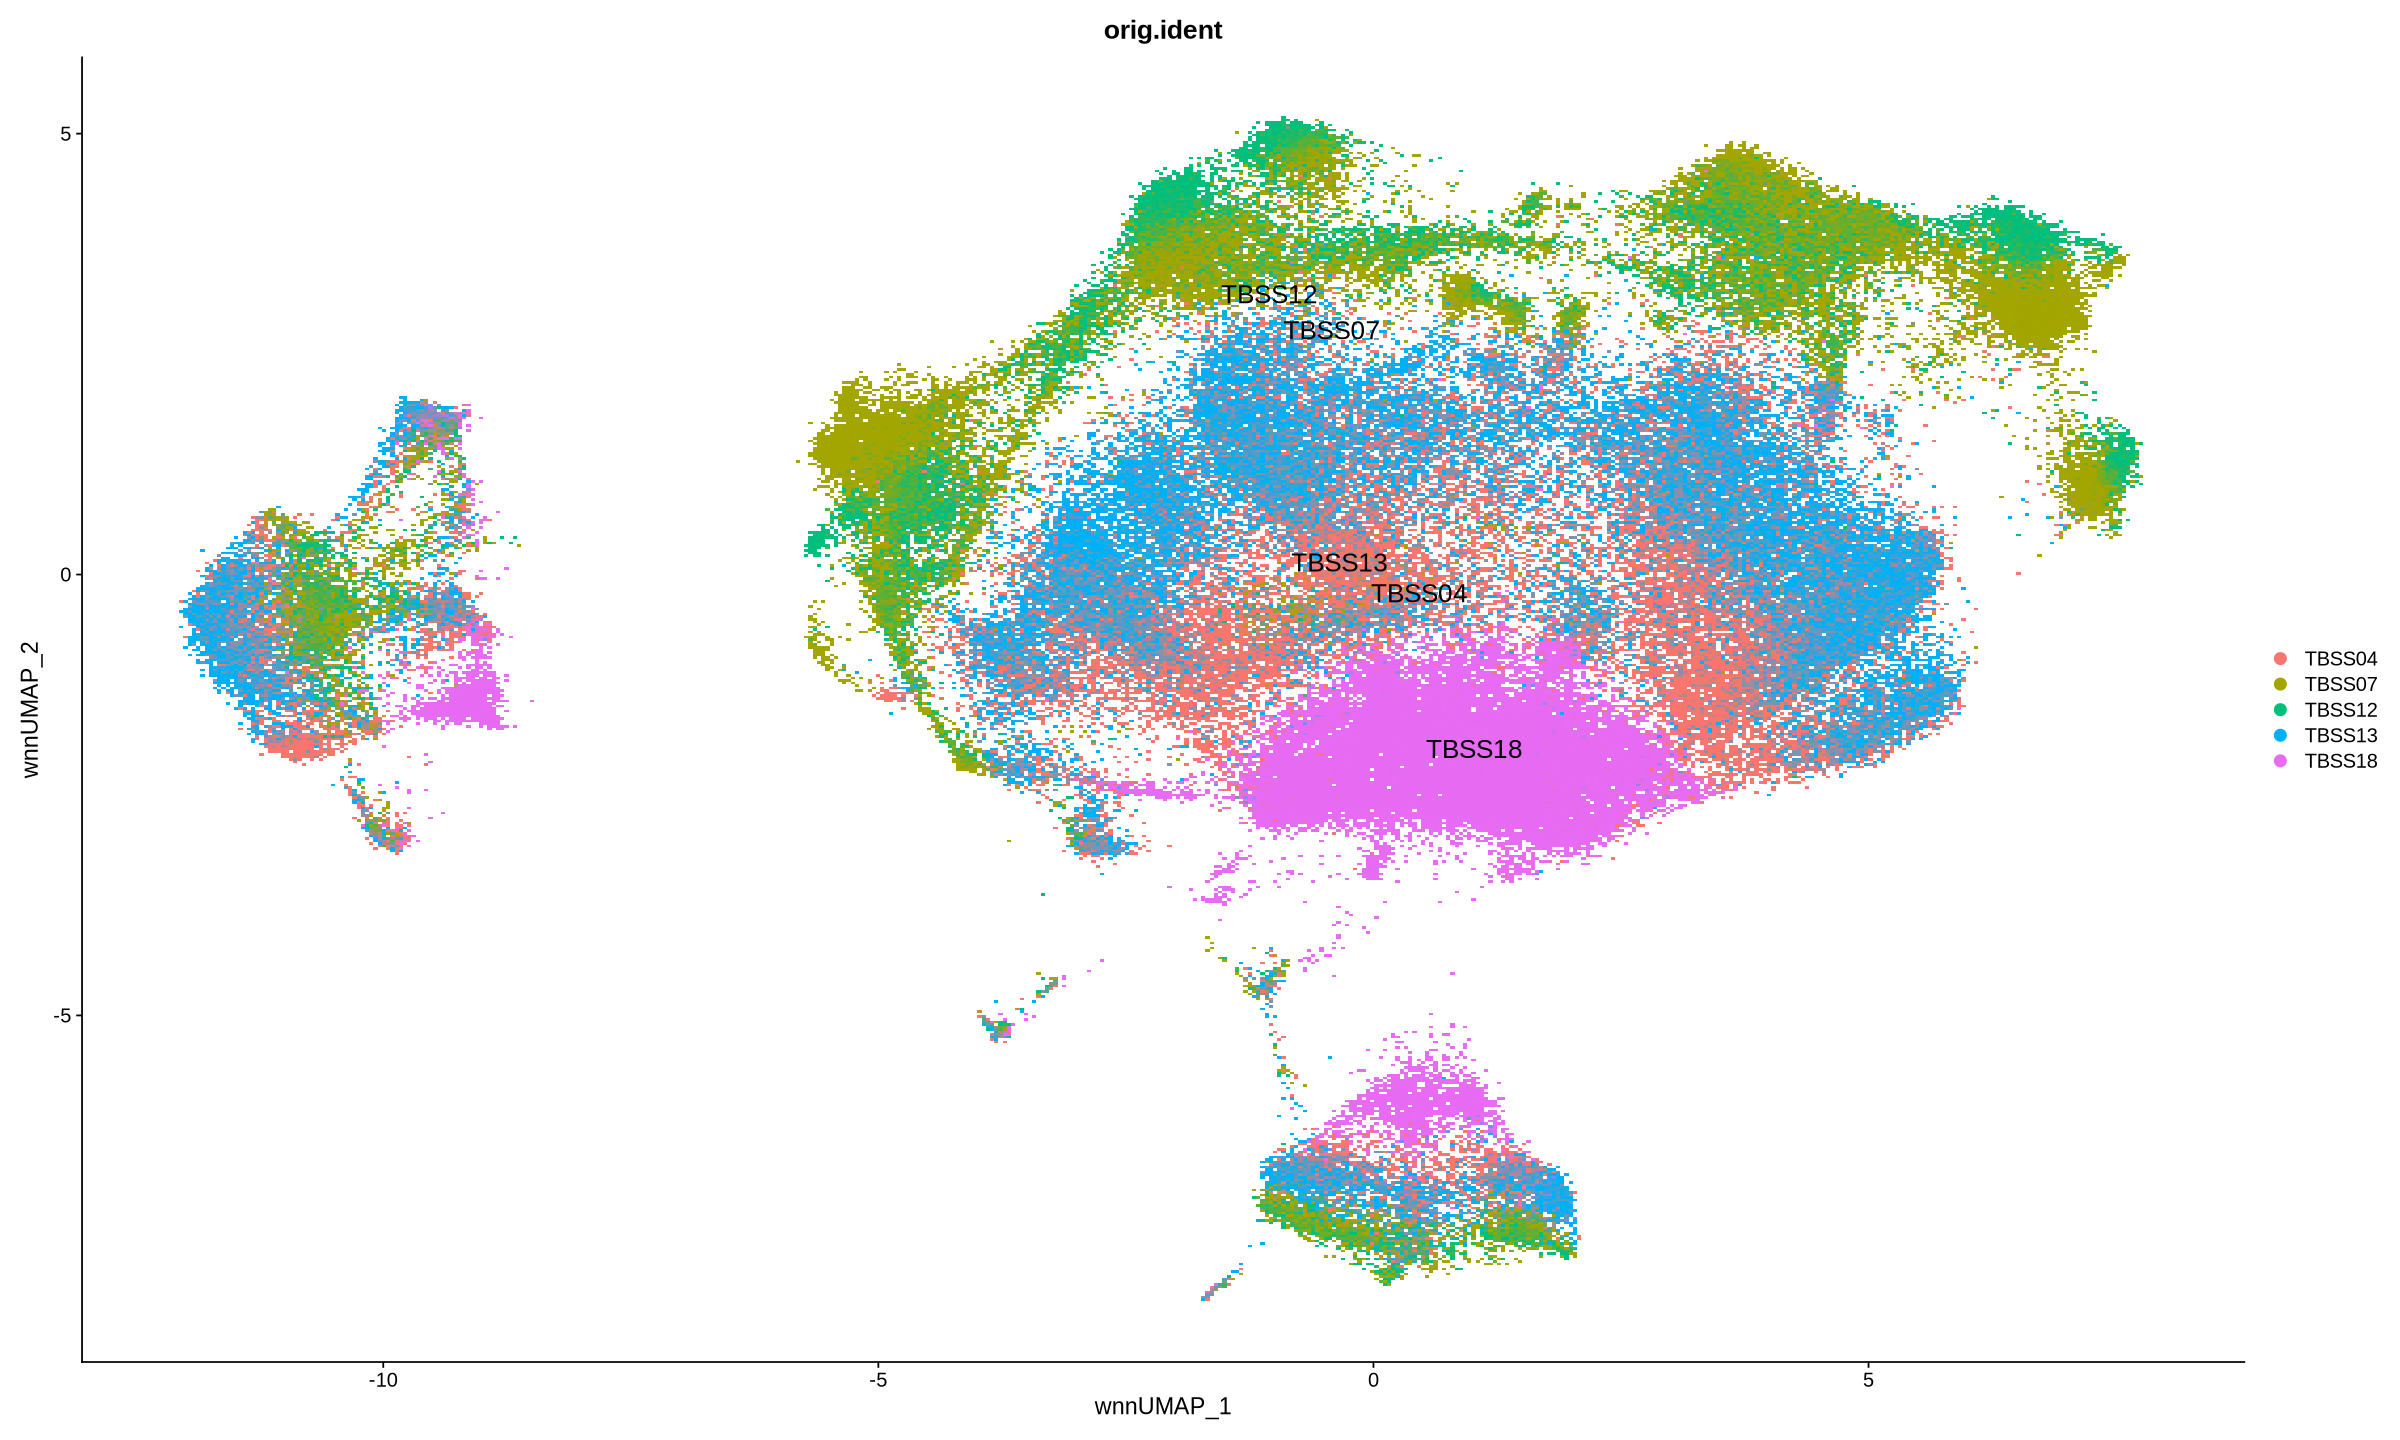

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



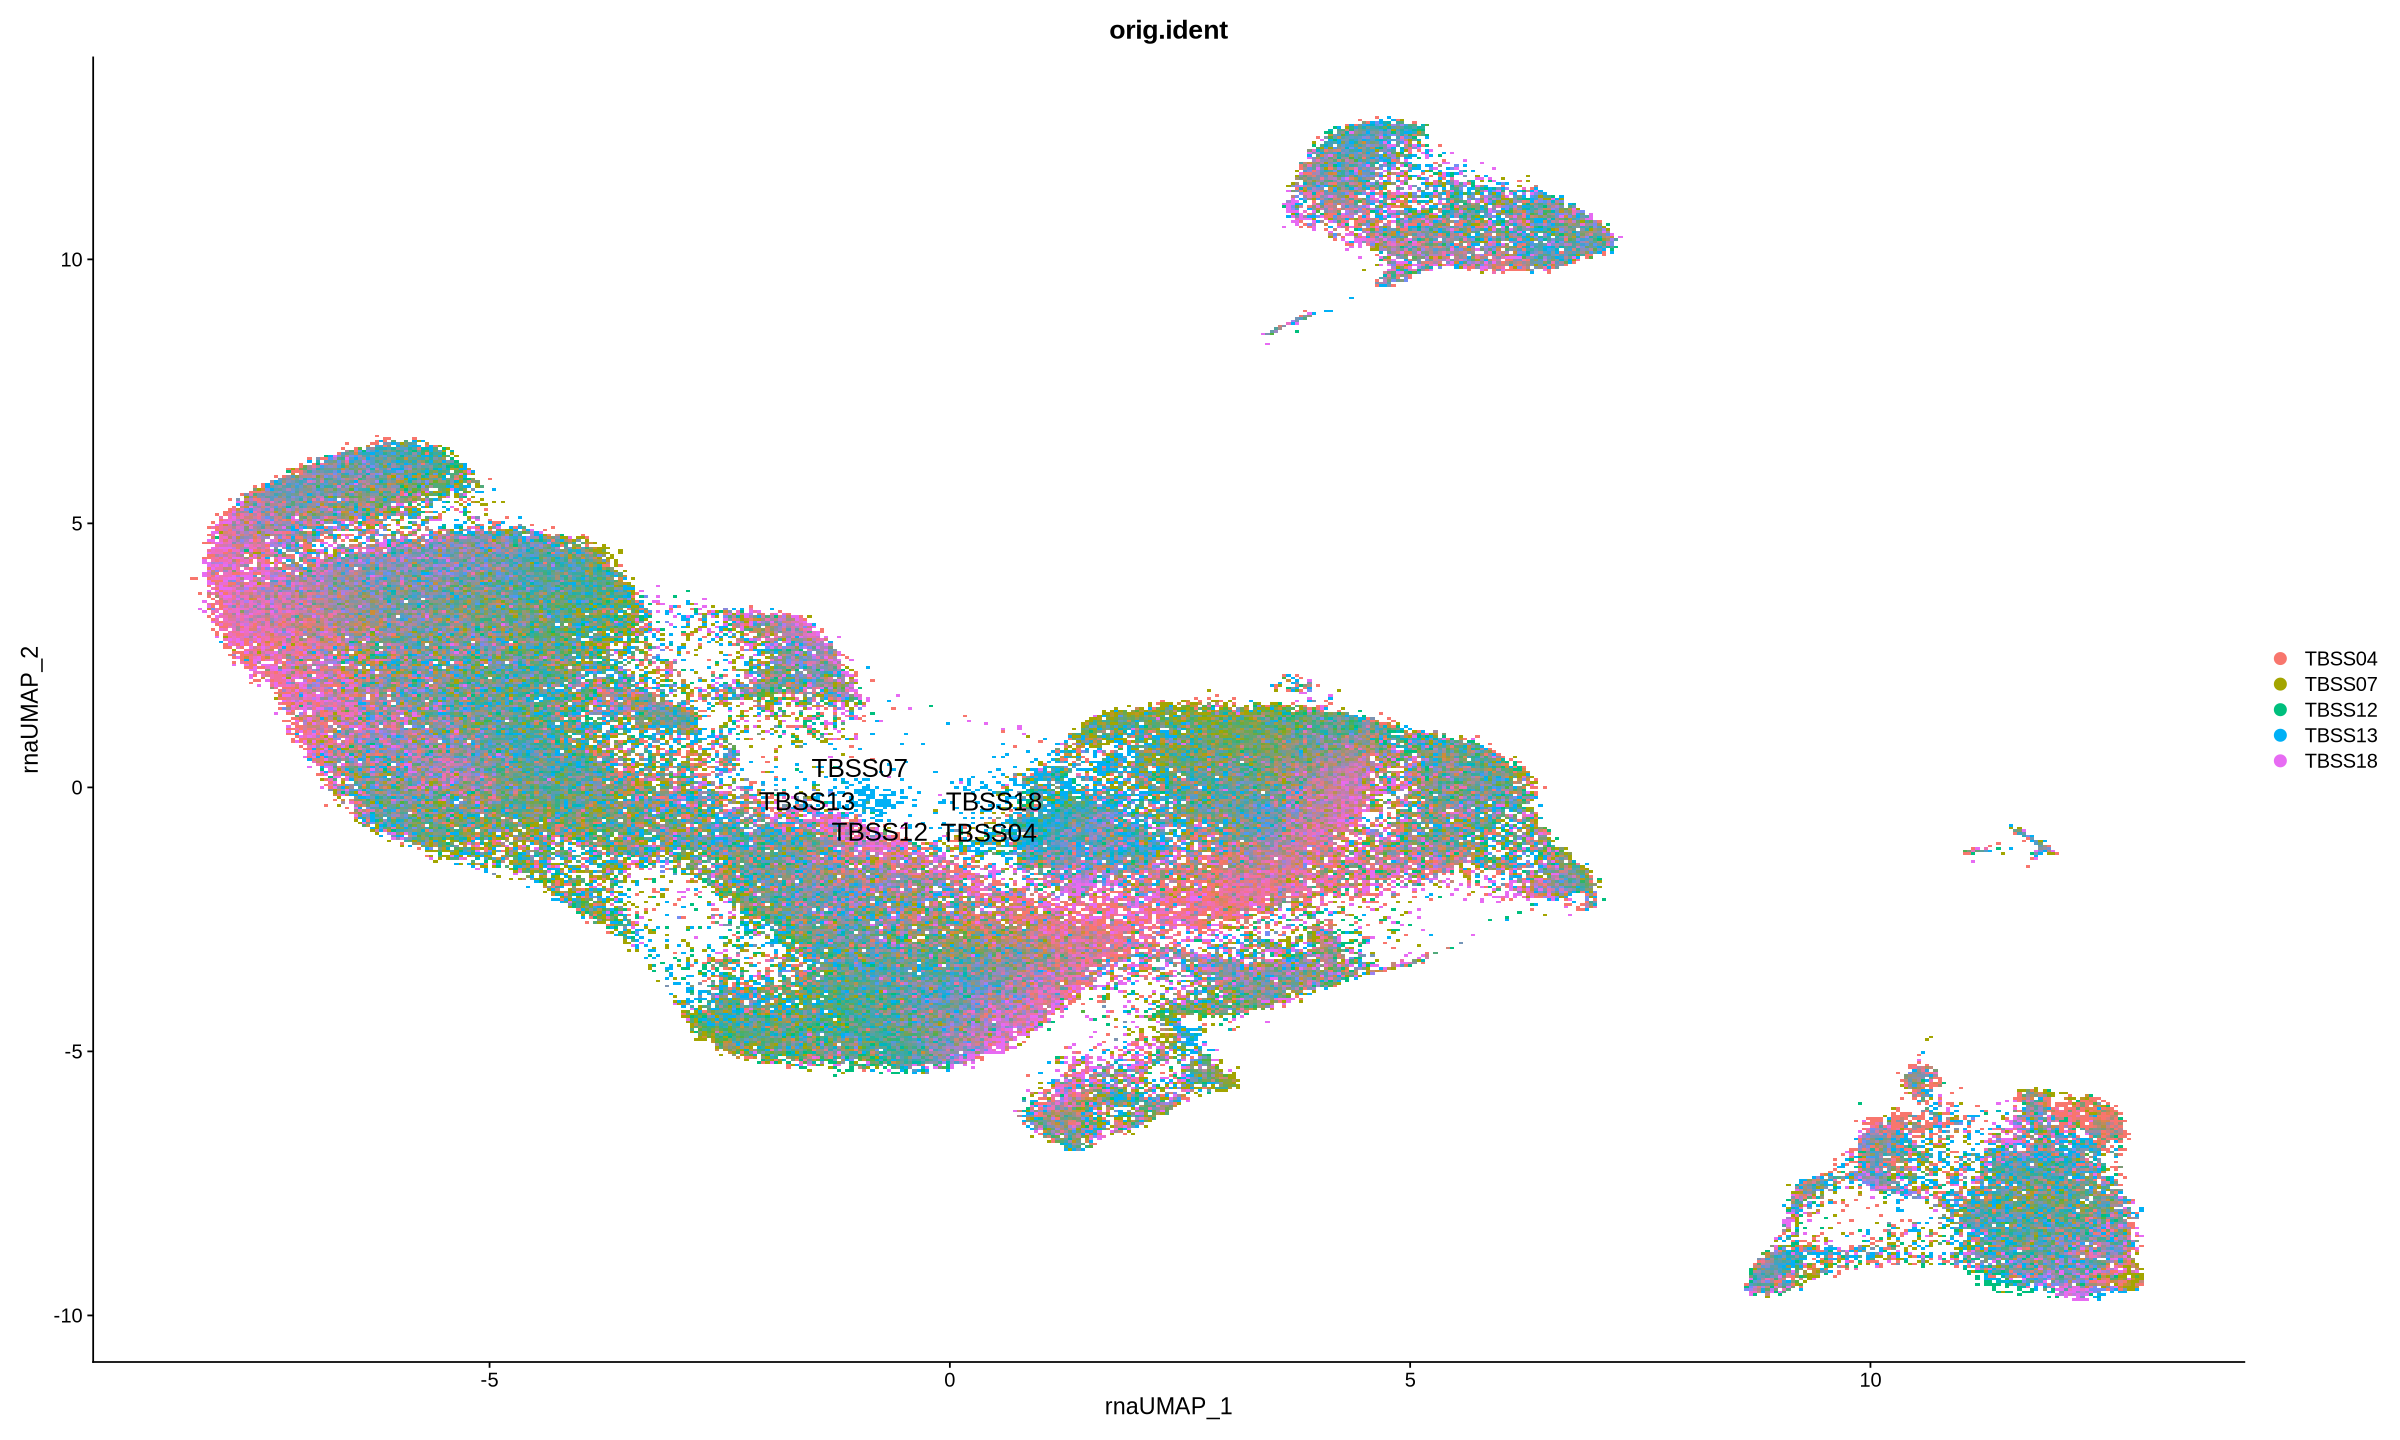

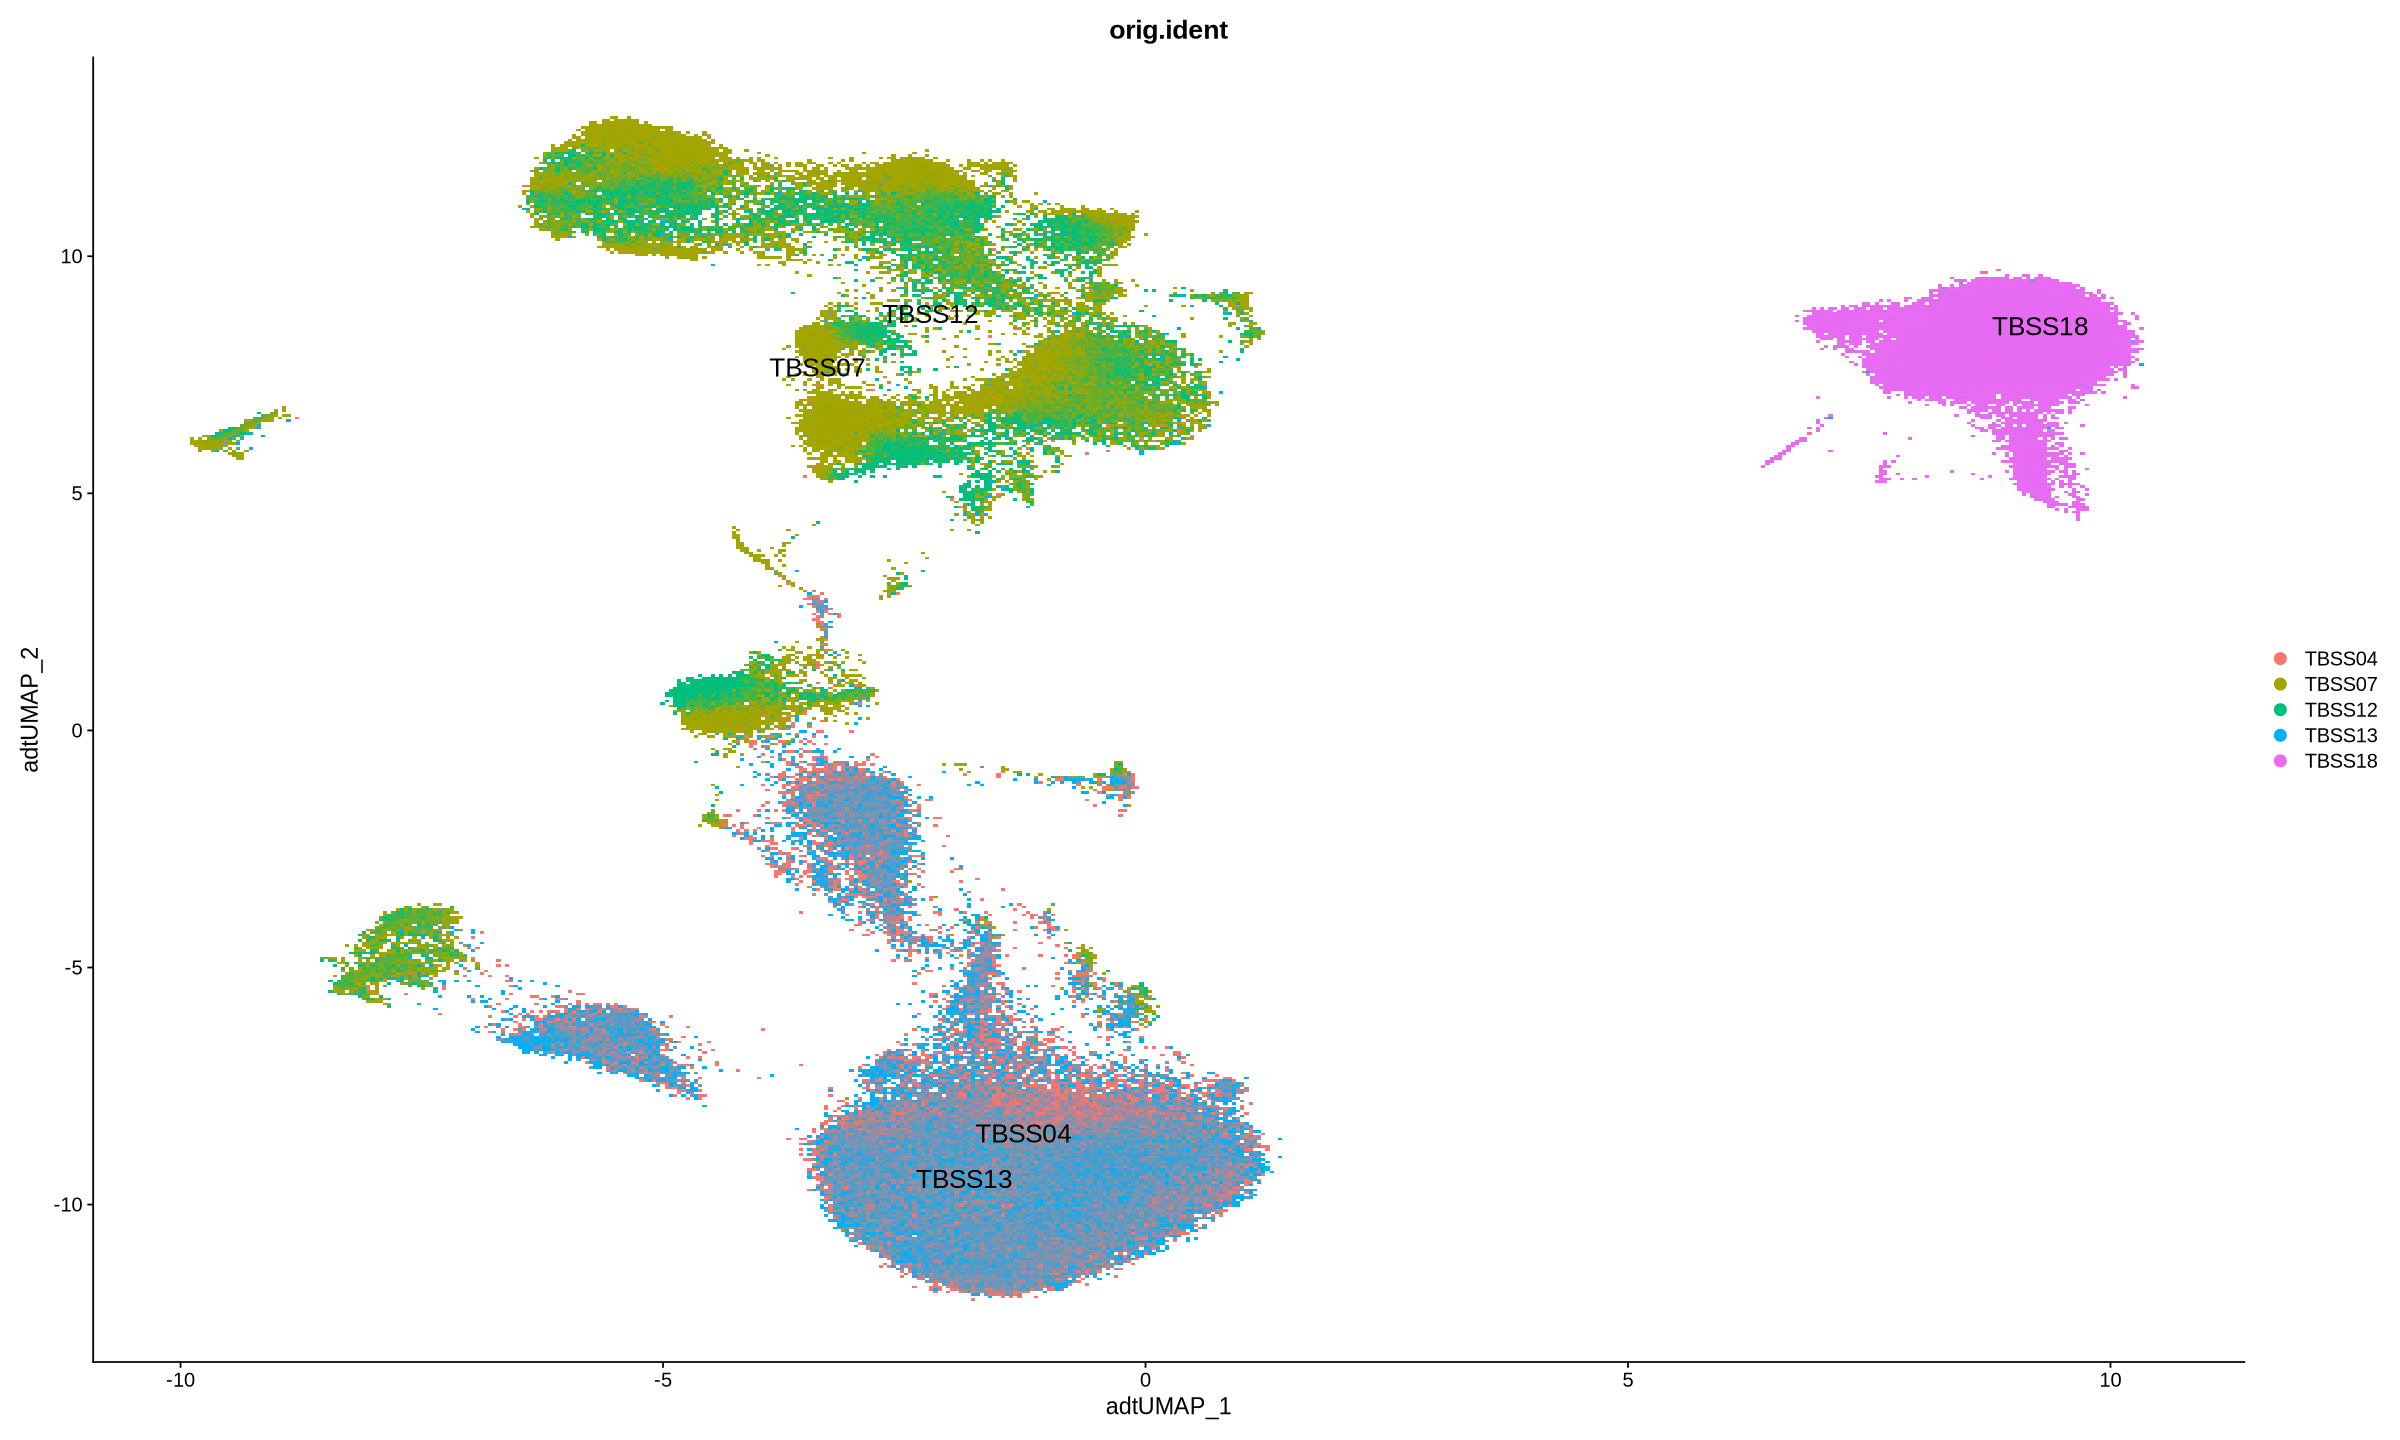

In [23]:
DimPlot(combined, reduction = 'wnn.umap',  group.by = 'orig.ident' , label = TRUE, repel = TRUE, label.size = 5.5) 

DimPlot(combined, reduction = 'rna.umap',  group.by = 'orig.ident' , label = TRUE, repel = TRUE, label.size = 5.5) 
DimPlot(combined, reduction = 'adt.umap',  group.by = 'orig.ident' , label = TRUE, repel = TRUE, label.size = 5.5) 

In [21]:
saveRDS(combined, file = "/share/hennlab/projects/NCR_scRNAseq/results/seurat/combined_nointegration_multimodal.rds")

In [24]:
features <- SelectIntegrationFeatures(object.list = seurat_list)

anchors <- FindIntegrationAnchors(object.list = seurat_list, anchor.features = features)

integrated <- IntegrateData(anchorset = anchors)

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object3 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object4 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object5 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Scaling features for provided objects

Warning message:
“No layers found matching search pattern provided”


ERROR: [1m[33mError[39m in `ScaleData()`:[22m
[33m![39m No layer matching pattern 'data' found. Please run NormalizeData and retry


In [ ]:
DefaultAssay(integrated) <- "integrated"
integrated <- ScaleData(integrated)
integrated <- RunPCA(integrated)
integrated <- RunUMAP(integrated, dims = 1:30) 

In [ ]:
str(seurat_list)

In [ ]:
str(integrated)

In [10]:
saveRDS(seurat_list, file = "/share/hennlab/projects/NCR_scRNAseq/results/seurat/seuratlist.rds")
saveRDS(integrated, file = "/share/hennlab/projects/NCR_scRNAseq/results/seurat/integrated.rds")
print("done")

[1] "done"


In [ ]:
seurat_list <- readRDS("/share/hennlab/projects/NCR_scRNAseq/results/seurat/seuratlist.rds")

In [24]:
integrated <- readRDS("/share/hennlab/projects/NCR_scRNAseq/results/seurat/integrated.rds")

In [25]:
unique(integrated@meta.data$orig.ident)

[1] "TBSS04" "TBSS07" "TBSS12" "TBSS13" "TBSS18"

In [7]:
harmonised <- NormalizeData(combined)
harmonised <- FindVariableFeatures(harmonised)
harmonised <- ScaleData(harmonised)


Normalizing layer: counts.TBSS04.SeuratProject.SeuratProject.SeuratProject

Normalizing layer: counts.TBSS07.SeuratProject.SeuratProject.SeuratProject

Normalizing layer: counts.TBSS12.SeuratProject.SeuratProject

Normalizing layer: counts.TBSS13.SeuratProject

Normalizing layer: counts.TBSS18

Finding variable features for layer counts.TBSS04.SeuratProject.SeuratProject.SeuratProject

Finding variable features for layer counts.TBSS07.SeuratProject.SeuratProject.SeuratProject

Finding variable features for layer counts.TBSS12.SeuratProject.SeuratProject

Finding variable features for layer counts.TBSS13.SeuratProject

Finding variable features for layer counts.TBSS18

Centering and scaling data matrix



In [ ]:
harmonised  <- RunPCA(harmonised, assay = "RNA")
DimPlot(harmonised, reduction = "pca", group.by = "orig.ident")
VlnPlot(harmonised, features = c("nFeature_RNA"), group.by = "orig.ident") + guides(fill = "none") 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



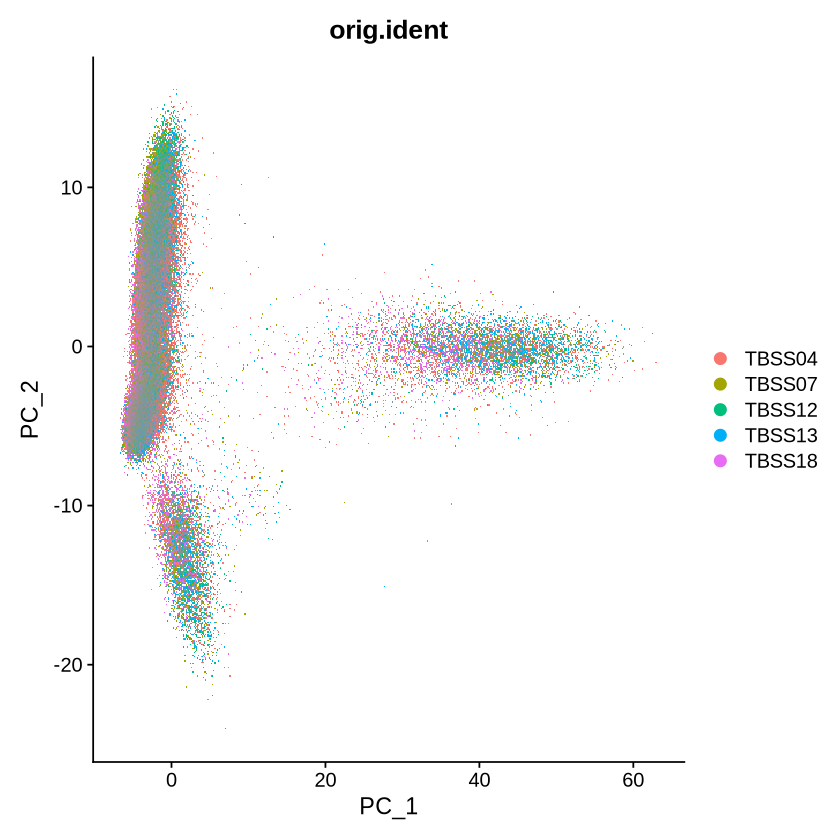

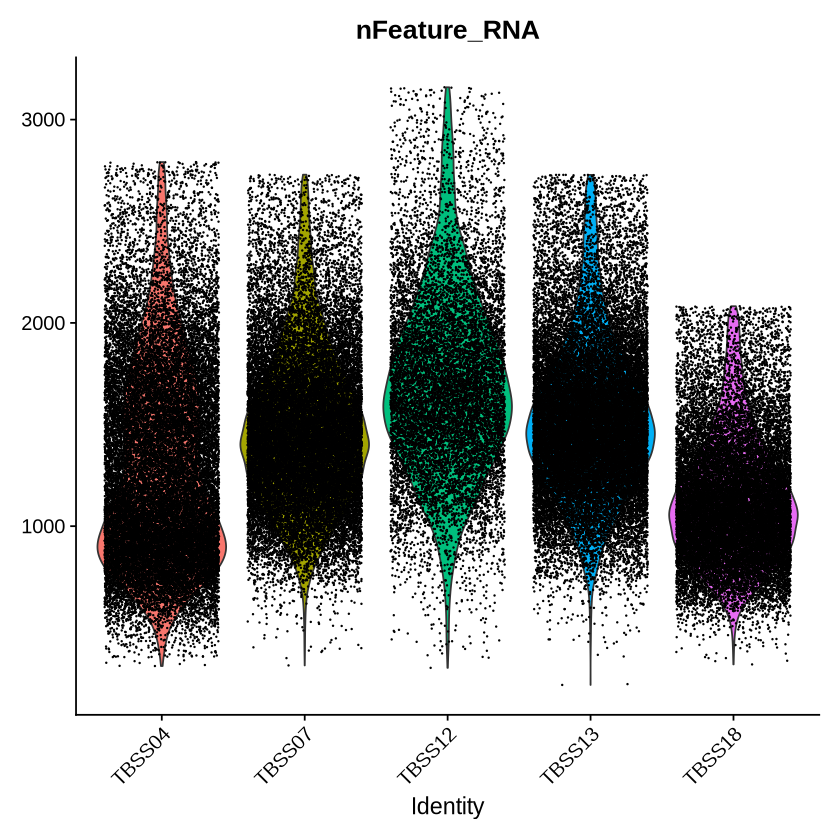

Transposing data matrix

Initializing state using k-means centroids initialization

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 5646000)”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



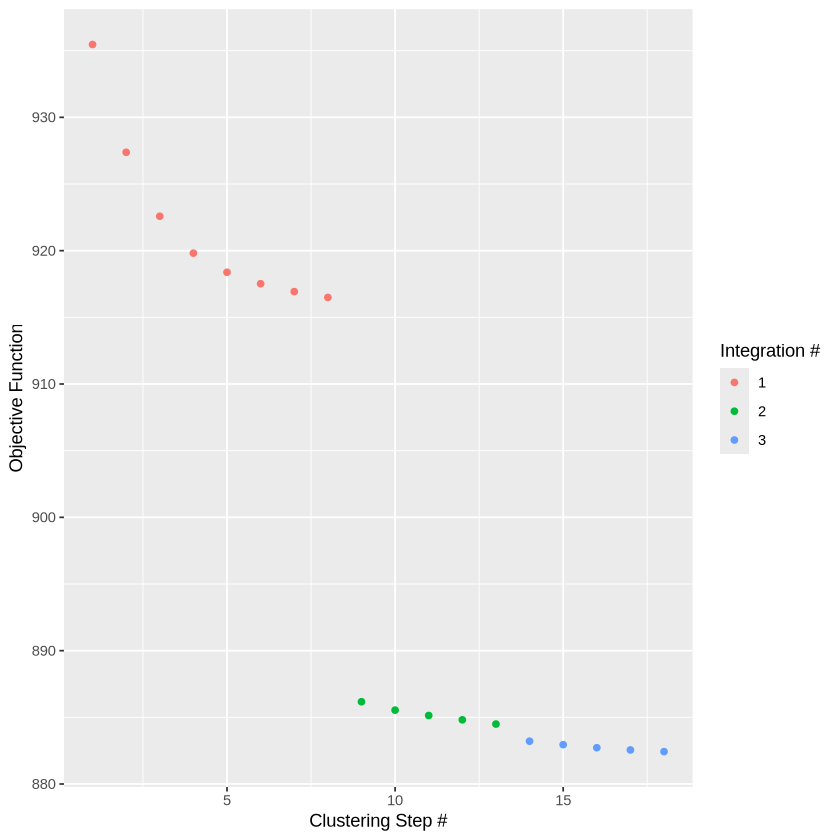

In [12]:
harmonised<- RunHarmony(harmonised, "orig.ident", plot_convergence = TRUE)
str(harmonised)
harmonised <- RunUMAP(harmonised, reduction = "harmony",dims = 1:30) 

In [17]:
saveRDS(harmonised, file = "/share/hennlab/projects/NCR_scRNAseq/results/seurat/HARMONISED2025.rds")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



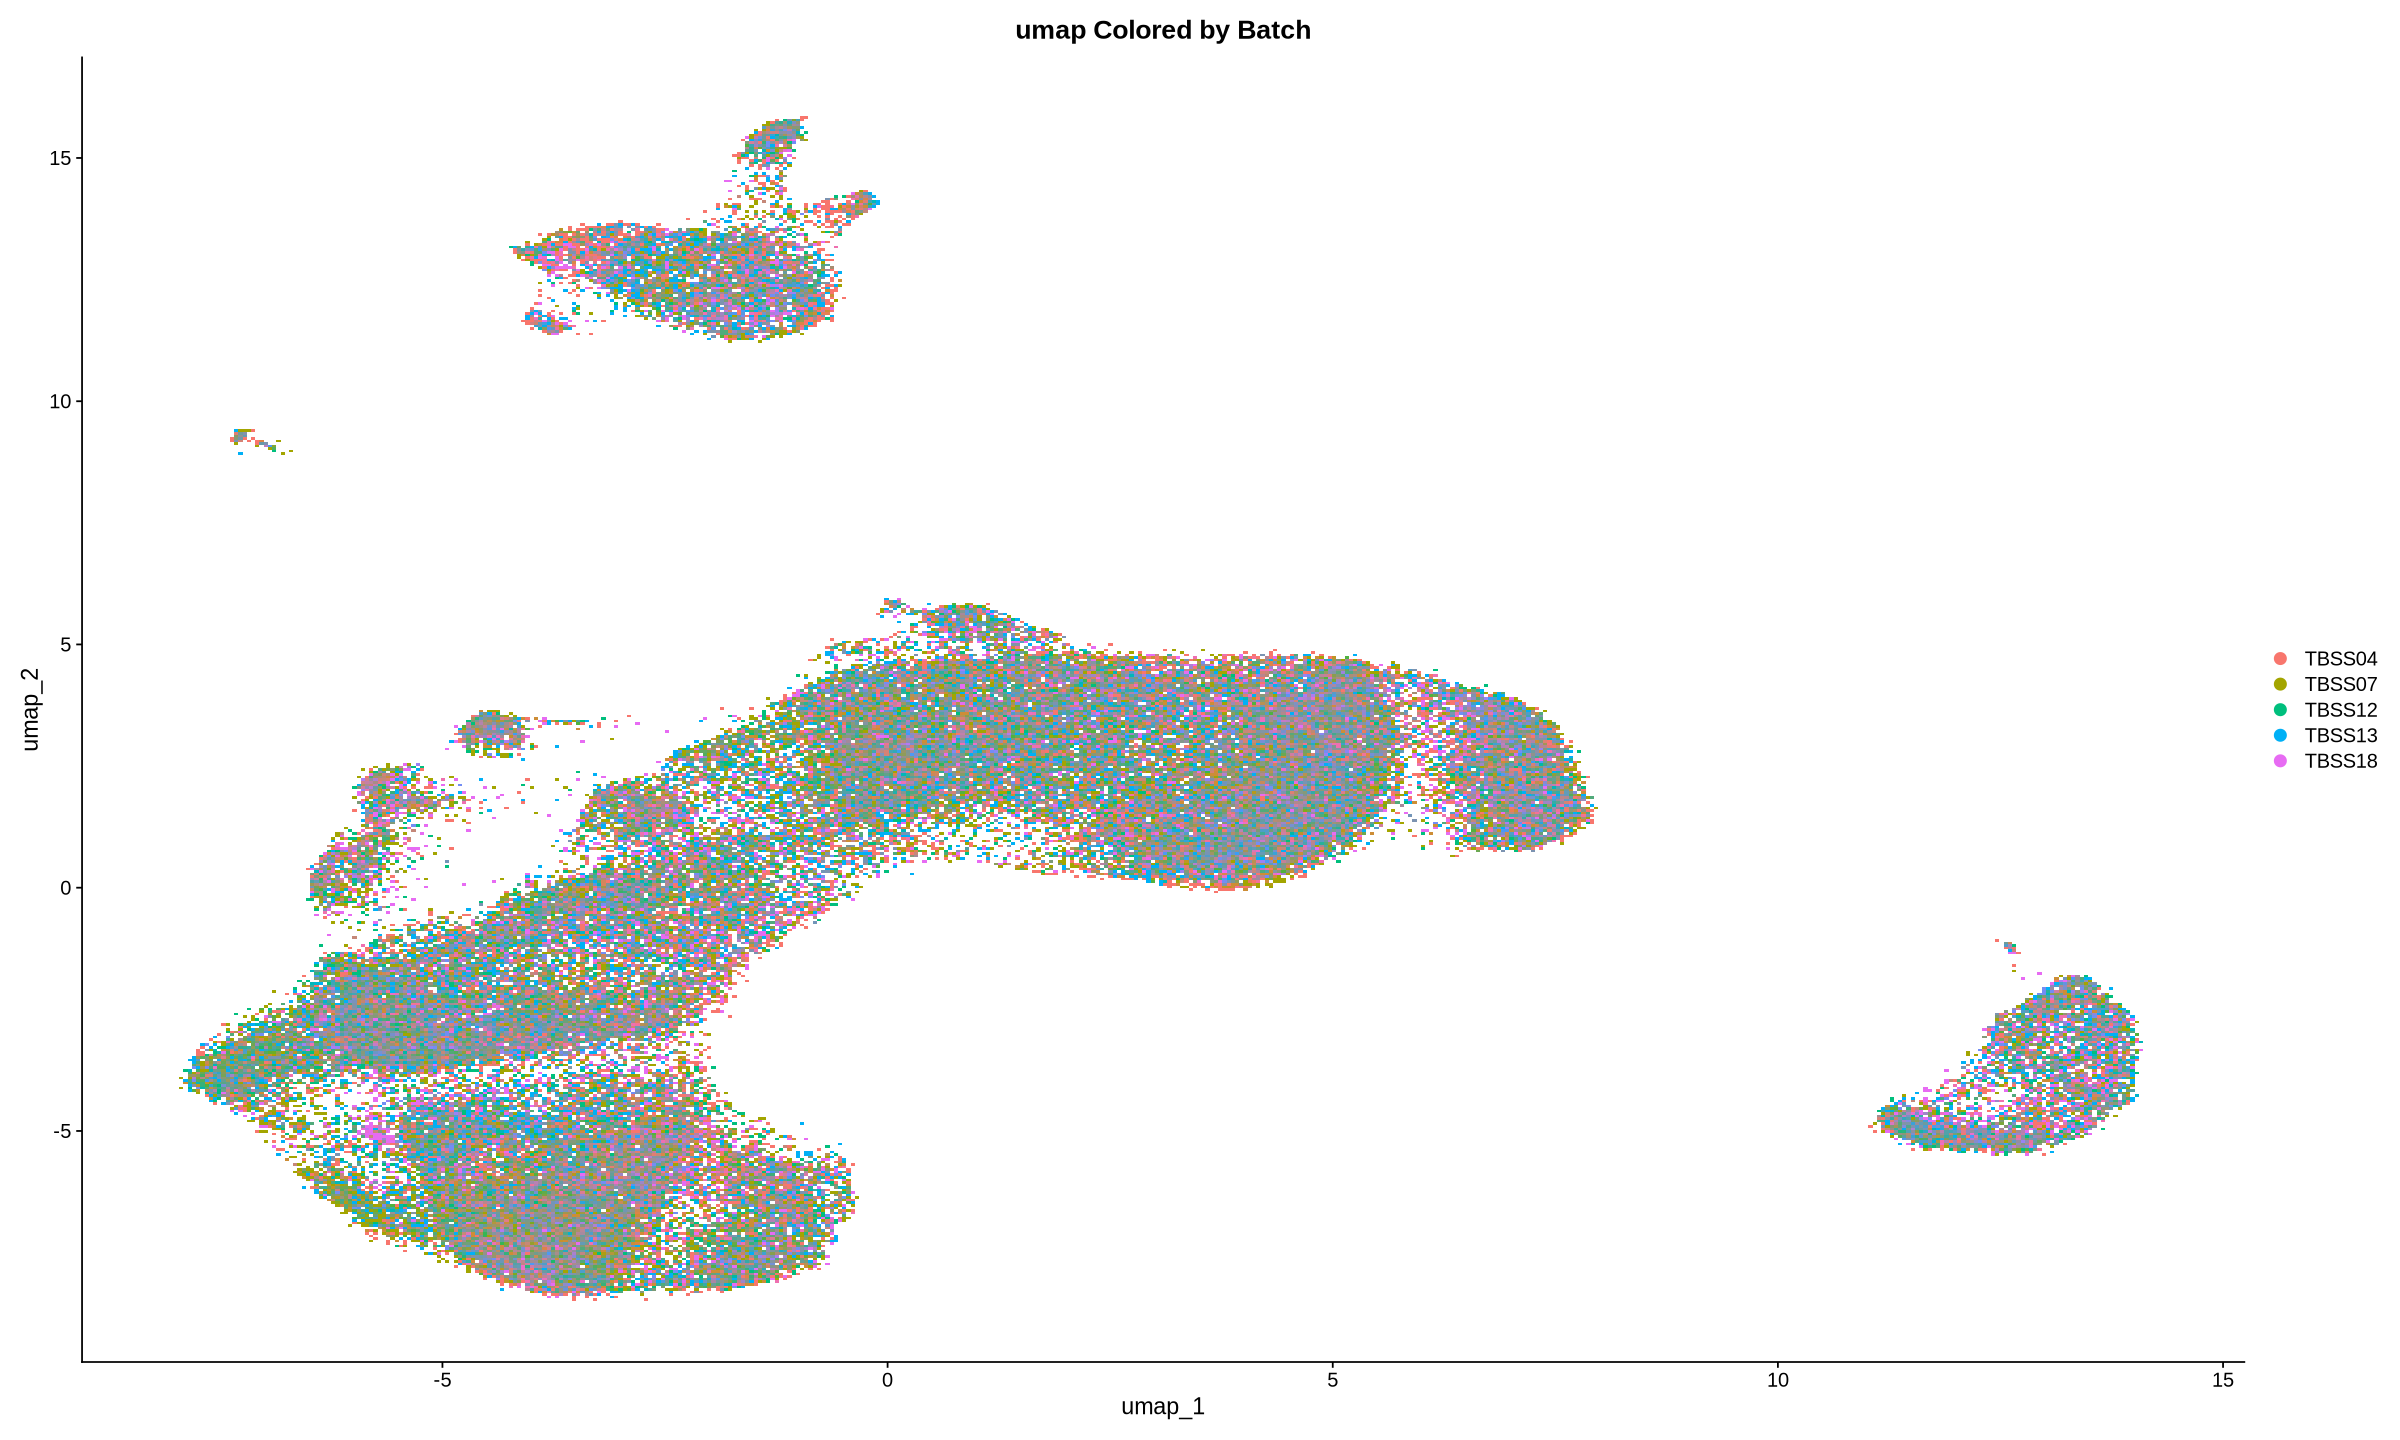

In [18]:
options(repr.plot.width = 20, repr.plot.height = 12)
DimPlot(harmonised, reduction = "umap", group.by = "orig.ident", dims = c(1, 2)) +
  ggtitle("umap Colored by Batch")

In [16]:
options(repr.plot.width = 20, repr.plot.height = 12)
DimPlot(integrated, reduction = "umap", group.by = "orig.ident", dims = c(1, 2)) +
  ggtitle("umap Colored by Batch")

ERROR: Error: object 'integrated' not found


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



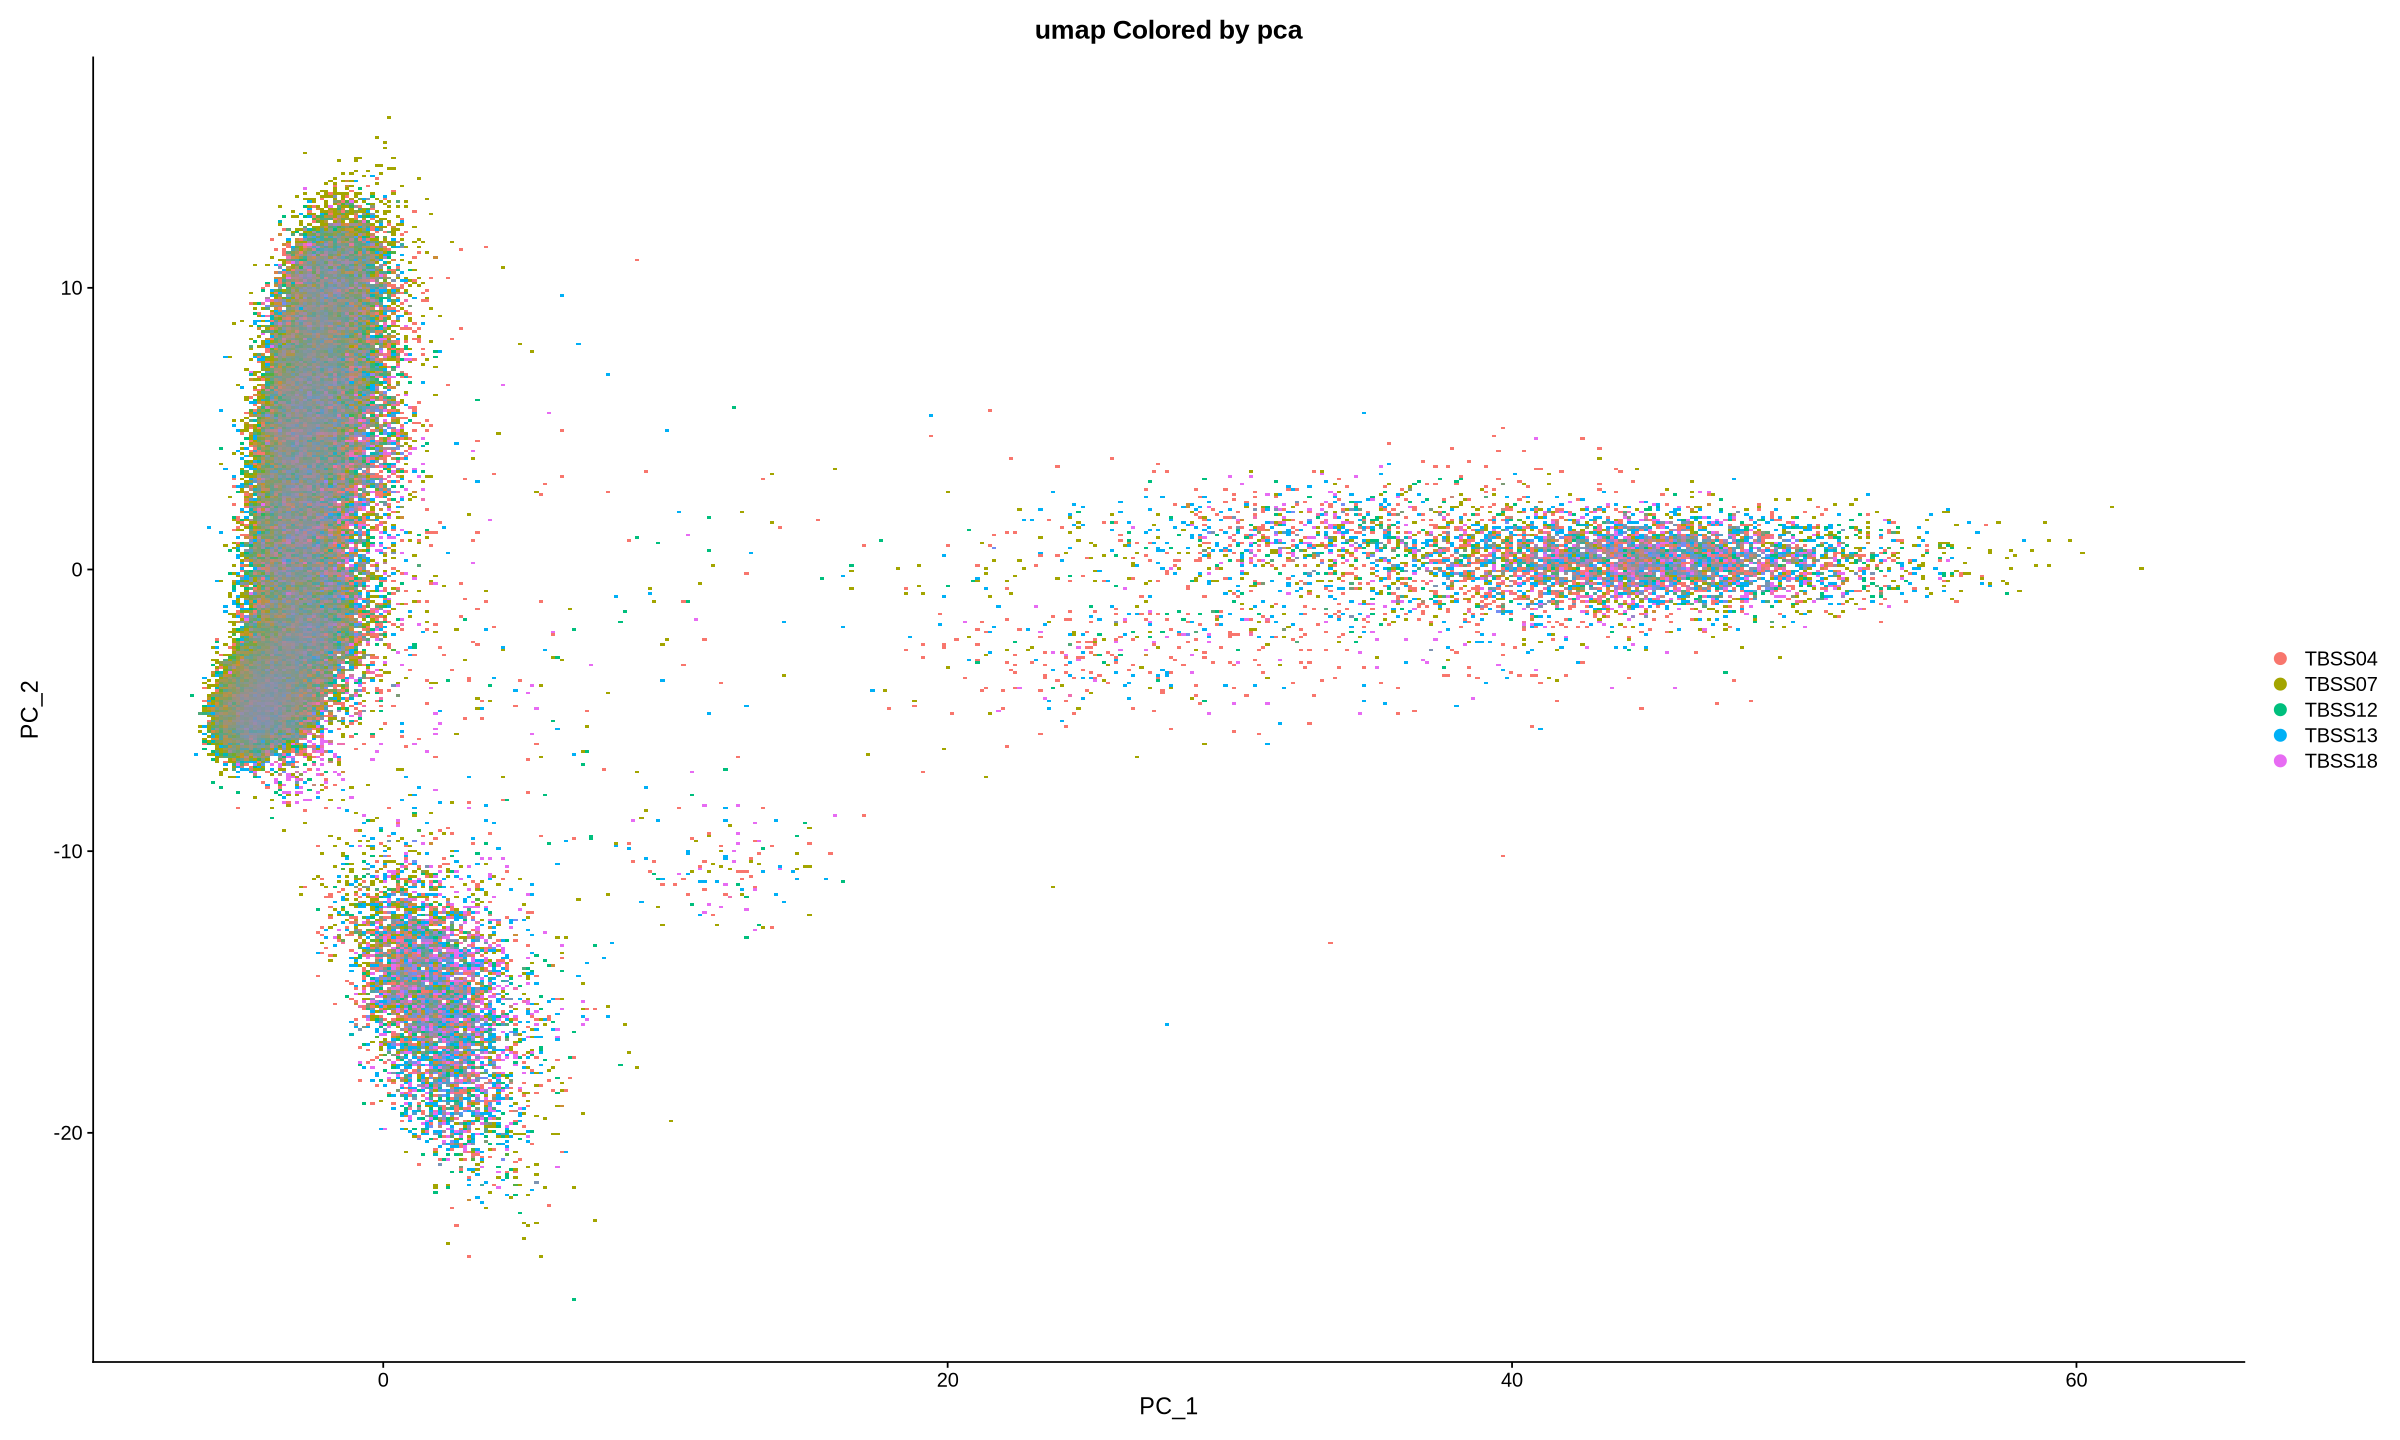

In [9]:
options(repr.plot.width = 20, repr.plot.height = 12)
DimPlot(integrated, reduction = "pca", group.by = "orig.ident") +
  ggtitle("umap Colored by pca")

In [13]:
options(repr.plot.width = 20, repr.plot.height = 12)
table(integrated@meta.data$orig.ident)



TBSS04 TBSS07 TBSS12 TBSS13 TBSS18 
 26008  25675  12283  27450  21504 

Warning message:
“Could not find TRGC2 in the default search locations, found in ‘RNA’ assay instead”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



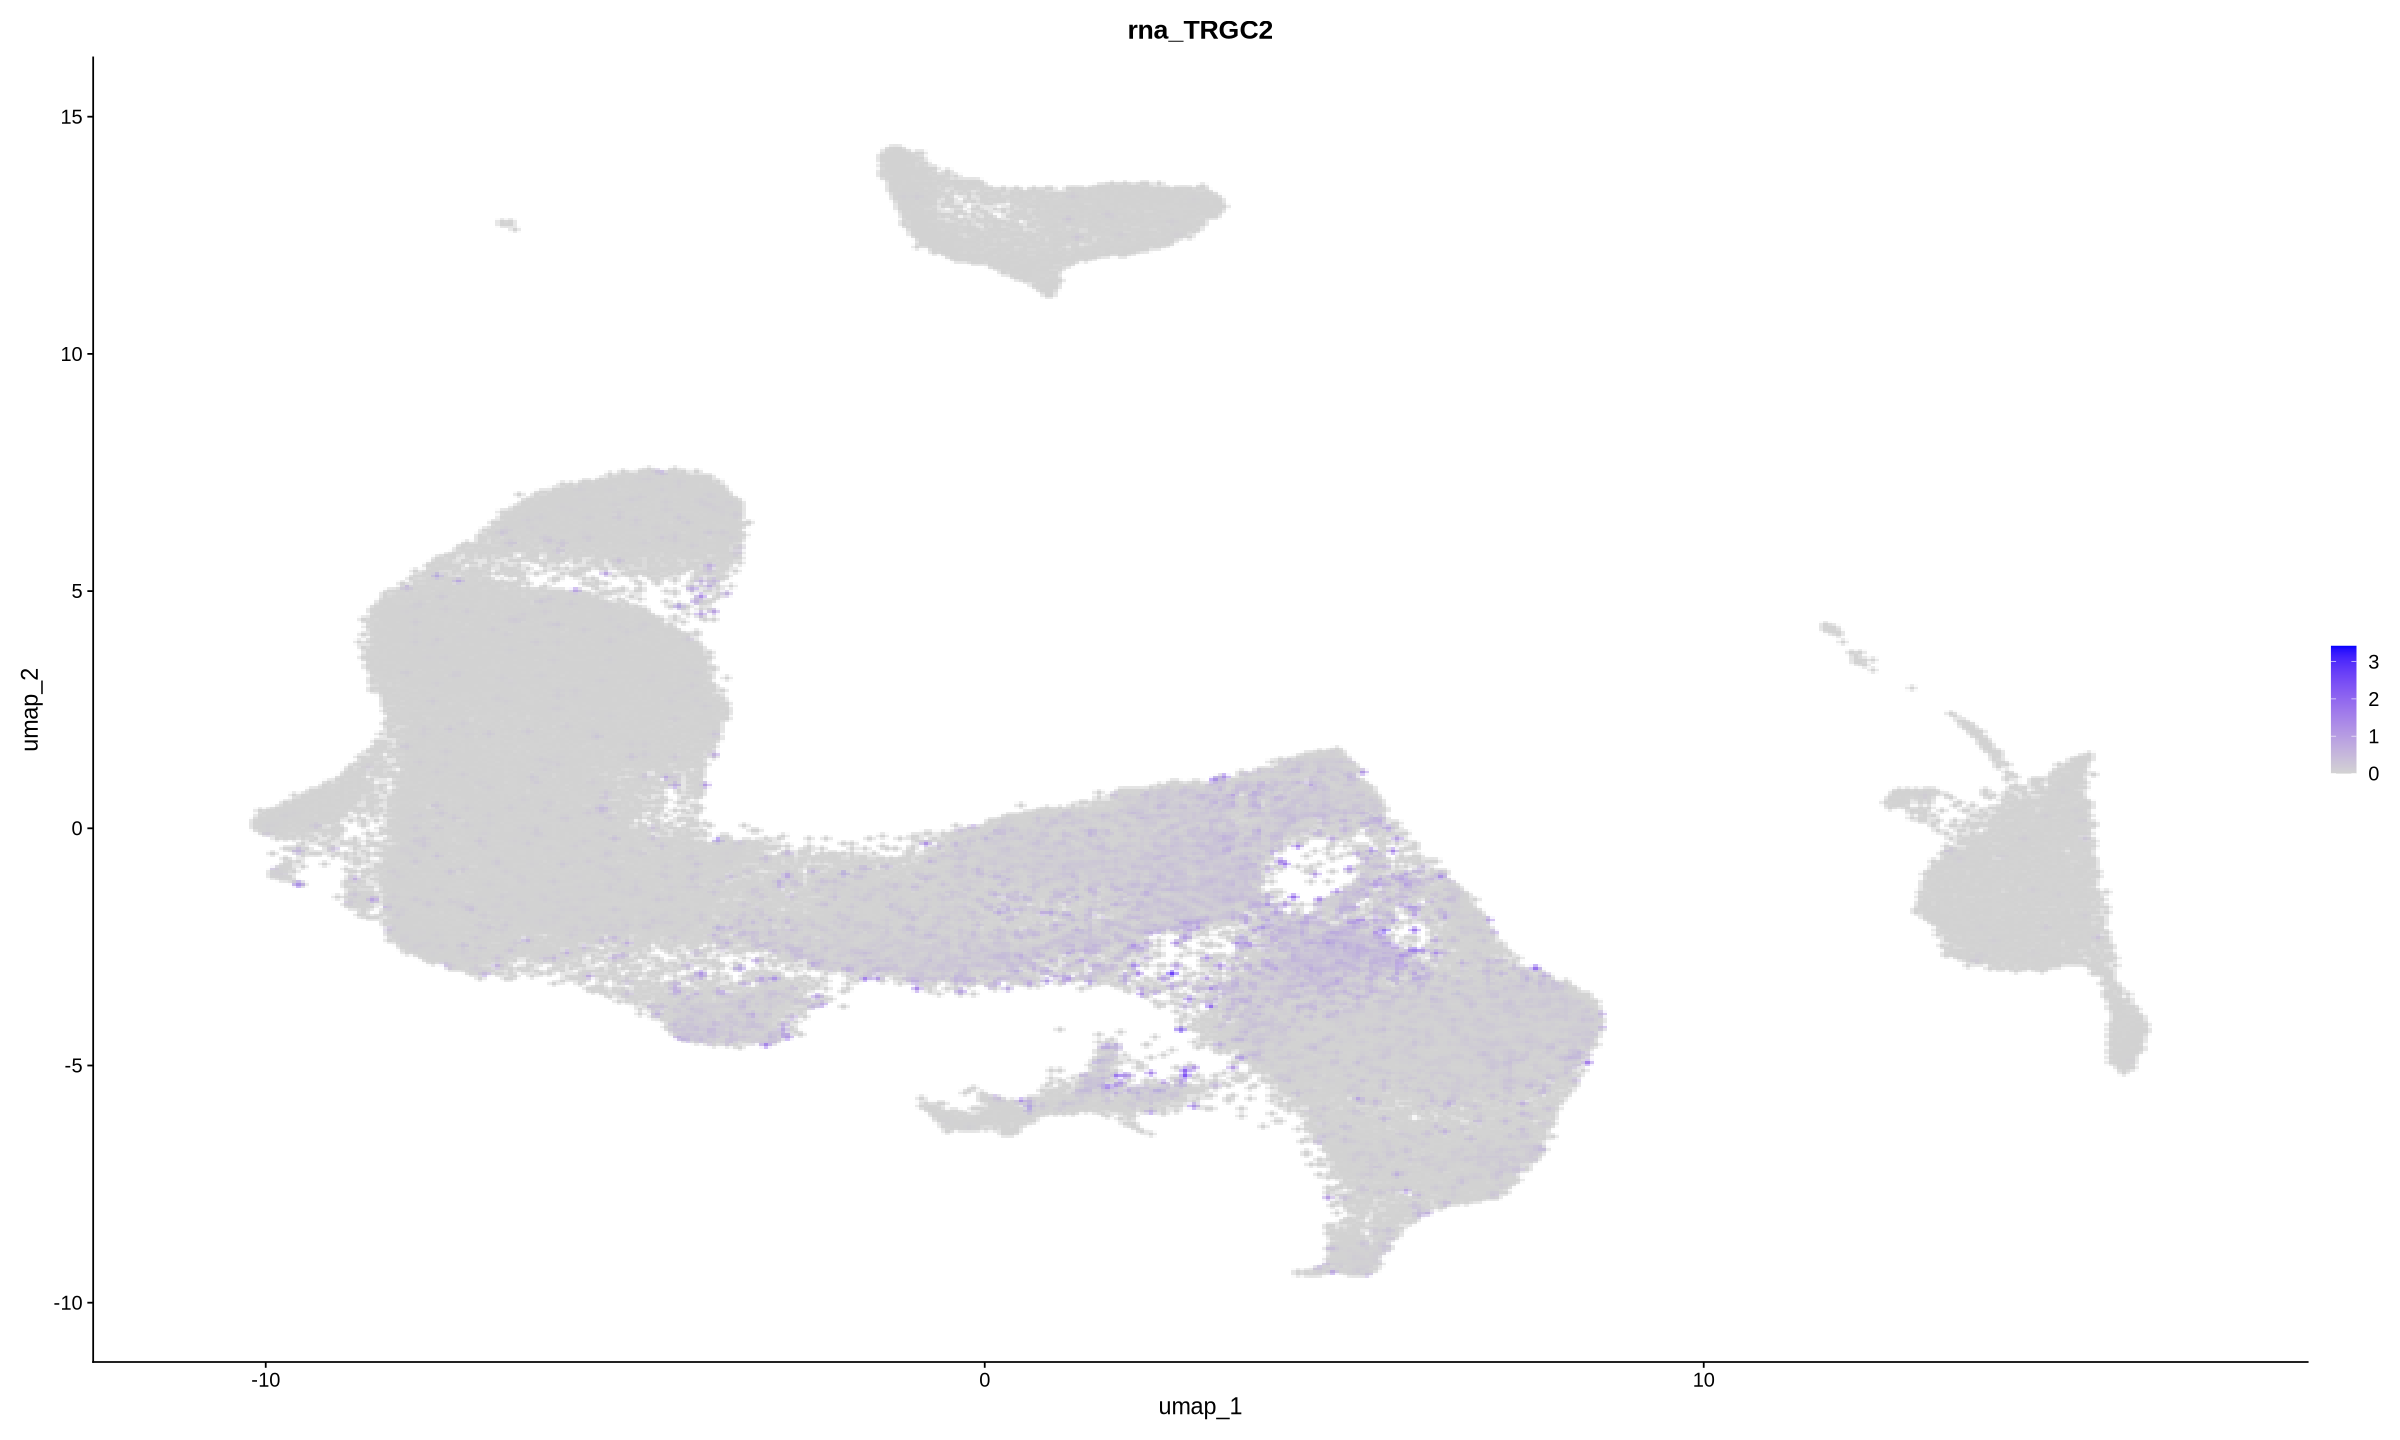

In [19]:
FeaturePlot(
  integrated, 
  features = "TRGC2", 
  reduction = "umap", 
  pt.size = 1.5
) 

In [19]:
# start cell type annotation
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/gene_sets_prepare.R")
# load cell type annotation function
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_score_.R")
gs.list <- gene_sets_prepare("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/ScTypeDB_short.xlsx", "Immune system") # e.g. Imm
es.max <- sctype_score(GetAssayData(integrated, assay = "integrated", layer = "scale"),
                       scaled = TRUE,
                       gs = gs.list$gs_positive,
                       gs2 = gs.list$gs_negative)

In [26]:

# harmonised, used to be integrated,

In [27]:
# merge by cluster
cL_resutls <- do.call("rbind", lapply(unique(integrated@meta.data$seurat_clusters), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(integrated@meta.data[integrated@meta.data$seurat_clusters==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(integrated@meta.data$seurat_clusters==cl)), 10)
}))
sctype_scores <- cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  

In [28]:
#just a visual to see whats happeneng above, were taking the cell type wiuht top score for each cluster
head(cL_resutls)
head(sctype_scores)

,cluster,type,scores,ncells
,<chr>,<chr>,<dbl>,<int>
ISG expressing immune cells,14,ISG expressing immune cells,7803.311,3291
CD8+ NKT-like cells,14,CD8+ NKT-like cells,4765.210,3291
CD4+ NKT-like cells,14,CD4+ NKT-like cells,4202.449,3291
Natural killer cells,14,Natural killer cells,3582.001,3291
Effector CD8+ T cells,14,Effector CD8+ T cells,2209.089,3291
γδ-T cells,14,γδ-T cells,1663.346,3291


cluster,type,scores,ncells
<chr>,<chr>,<dbl>,<int>
14,ISG expressing immune cells,7803.311,3291
11,ISG expressing immune cells,2057.381,4303
4,Effector CD8+ T cells,1644.231,6853
25,Non-classical monocytes,3022.881,991
6,Naive CD4+ T cells,2621.679,6184
8,Naive CD4+ T cells,3234.127,5246


In [29]:
sctype_scores <- sctype_scores %>%
  mutate(type = if_else(as.numeric(as.character(scores)) < ncells / 4, "Unknown", type))
print(sctype_scores[,1:3])


# A tibble: 40 × 3
# Groups:   cluster [40]
   cluster type                        scores
   <chr>   <chr>                        <dbl>
 1 14      ISG expressing immune cells  7803.
 2 11      ISG expressing immune cells  2057.
 3 4       Unknown                      1644.
 4 25      Non-classical monocytes      3023.
 5 6       Naive CD4+ T cells           2622.
 6 8       Naive CD4+ T cells           3234.
 7 10      Classical Monocytes          7374.
 8 1       Naive CD4+ T cells           4637.
 9 23      CD8+ NKT-like cells          2534.
10 20      Naive B cells                1930.
# ℹ 30 more rows


In [30]:
integrated@meta.data$sctype_classification = ""
for(j in unique(sctype_scores$cluster)){
  cl_type = sctype_scores[sctype_scores$cluster==j,]; 
  integrated@meta.data$sctype_classification[integrated@meta.data$seurat_clusters == j] = as.character(cl_type$type[1])
}

In [ ]:
DimPlot(integrated, reduction = "umap", label = TRUE, repel = TRUE, group.by = 'sctype_classification', label.size = 5) +theme(legend.title = element_text(size = 16),legend.text = element_text(size = 16))     # Adjust legend label siz

In [35]:
ncol(integrated)
ncol(harmonised)

[1] 112920

[1] 112920

In [32]:
markers <-read.csv("/share/hennlab/projects/NCR_scRNAseq/data/Markers.csv", na.strings = c("", "NA"))
#head(markers)
#markers[[marker == "CD19"]]$ADT_name
tcell_rna_markers <- na.omit(markers[markers$Cell.type == "T-cells", "RNA_name"])
bcell_rna_markers <- na.omit(markers[markers$Cell.type == "B-cell", "RNA_name"])
monocytes_rna_markers <- na.omit(markers[markers$Cell.type == "Monocytes", "RNA_name"])
nkcell_rna_markers <- na.omit(markers[markers$Cell.type == "NK-cells", "RNA_name"])
dendritic_cell_rna_markers <- na.omit(markers[markers$Cell.type == "Dendritic-Cell", "RNA_name"])


 

my_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
  "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173",
  "#5254a3", "#9c9ede", "#d6616b", "#b00b69", "#de9ed6"
)
adt_markers <- na.omit(markers$ADT_name)
 
 


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <b4>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <b3>”
Warning message in grid.Call

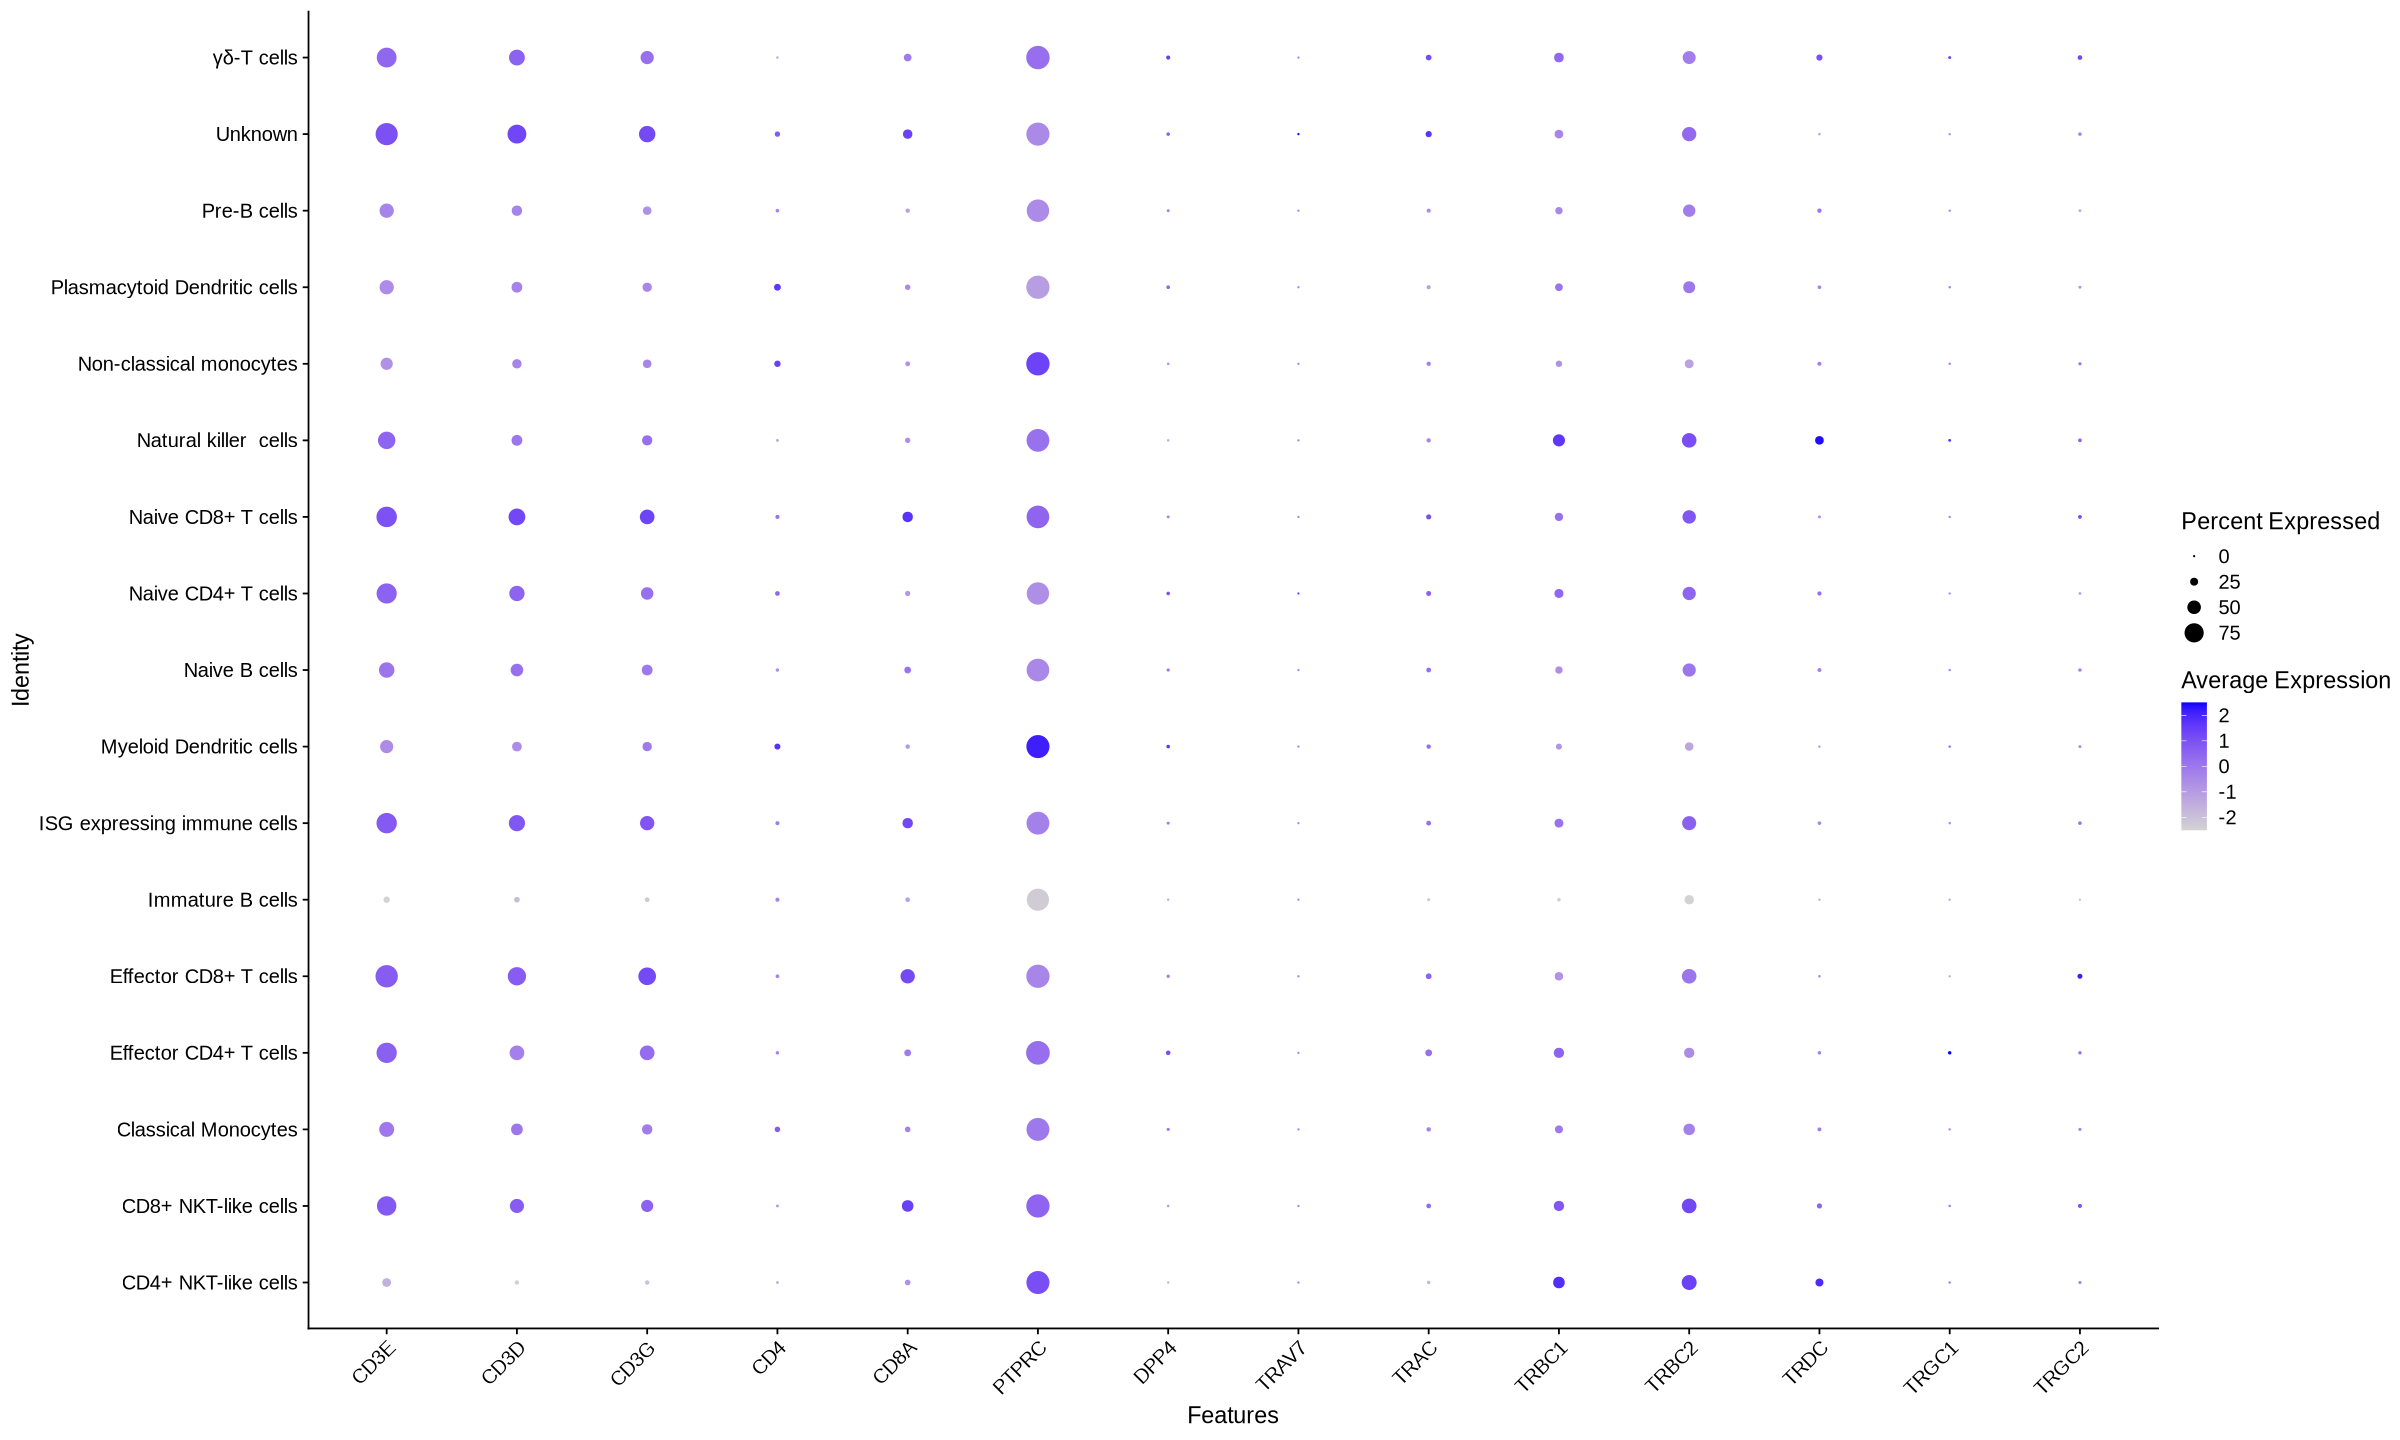

In [33]:
DotPlot(integrated, features = tcell_rna_markers, group.by = "sctype_classification", assay = "RNA") + RotatedAxis()  

In [ ]:
DotPlot(integrated, features = nkcell_rna_markers, group.by = "sctype_classification",  , assay = "RNA") + RotatedAxis()  

In [ ]:
DotPlot(integrated, features = bcell_rna_markers, group.by = "sctype_classification"  , assay = "RNA") + RotatedAxis()  

In [ ]:
DotPlot(integrated, features = dendritic_cell_rna_markers, group.by = "sctype_classification"  , assay = "RNA") + RotatedAxis()  

In [ ]:
DotPlot(integrated, features = monocytes_rna_markers, group.by = "sctype_classification"  , scale = FALSE, assay = "RNA") + RotatedAxis()  

In [ ]:
DotPlot(integrated, features = adt_markers, group.by = "sctype_classification"  , assay = "ADT") + RotatedAxis()  